## 提取所有像素進行CNN

In [2]:
import cv2
import numpy as np
import os
import zipfile
# from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__

'2.16.1'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## 處理訓練、測試圖片

In [3]:
path = './Datasets/cat_dog_1.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()


directory_train = './cat_dog_1/train'
directory_test = './cat_dog_1/test'
files_train = [os.path.join(directory_train, f) for f in sorted(os.listdir(directory_train))]
files_test = [os.path.join(directory_test, f) for f in sorted(os.listdir(directory_test))]

In [6]:
# 處理訓練圖片
height, width = 128, 128
images = []
classes = []

for image_path in files_train:
    try:
        image = cv2.imread(image_path)
        (H, W) = image.shape[:2] # 取高跟寬（每一張圖片高度及寬度不會相同）
    except:
        continue

    # 將圖像調整為指定的寬度和高度
    image = cv2.resize(image, (width, height))
    # 將圖像轉換為灰度
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 顯示圖像
    # cv2_imshow(image)

    # 將圖像展平為一維數組
    image = image.ravel()
    # print(image.shape)

    # 將圖像添加到圖像列表中
    images.append(image)

    # 根據圖像名稱確定類別（貓或狗）
    image_name = os.path.basename(os.path.normpath(image_path))
    class_name = 0 if image_name.startswith('c') else 1
    classes.append(class_name) # 將類別標籤添加到類別列表中

    
# 資料由list轉numpy
X_train = np.asarray(images)
y_train = np.asarray(classes)   

print(X_train.shape, y_train.shape)
print(y_train)

(4000, 16384) (4000,)
[0 0 0 ... 1 1 1]


In [7]:
# 處理測試圖片
images = []
classes = []
for image_path in files_test:
    try:
      image = cv2.imread(image_path)
      (H, W) = image.shape[:2]
    except:
      continue

    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # cv2_imshow(image)

    image = image.ravel() # 多維轉一維
    images.append(image)
    # print(image.shape)
    

    image_name = os.path.basename(os.path.normpath(image_path))
    class_name = 0 if image_name.startswith('c') else 1
    classes.append(class_name)
    # print(class_name)

X_test = np.asarray(images)
y_test = np.asarray(classes)

<Axes: xlabel='y_train', ylabel='count'>

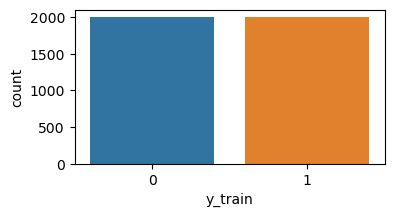

In [8]:

df = pd.DataFrame({'y_train': y_train}) # 将NumPy数组转换为Pandas DataFrame，并将列标记为分类变量
df['y_train'] = df['y_train'].astype('category')
plt.figure(figsize=(4, 2))  
sns.countplot(data=df, x='y_train')# 绘制计数直方图

<Axes: xlabel='y_test', ylabel='count'>

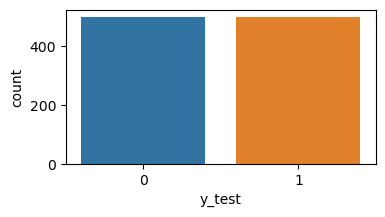

In [9]:
df = pd.DataFrame({'y_test': y_test}) # 将NumPy数组转换为Pandas DataFrame，并将列标记为分类变量
df['y_test'] = df['y_test'].astype('category')
plt.figure(figsize=(4, 2))  
sns.countplot(data=df, x='y_test')# 绘制计数直方图

## 資料正規化

In [10]:
print("原本資料")
print(X_train[0].max(), X_train[0].min()) # (236, 1)    ``

from sklearn.preprocessing import MinMaxScaler
# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()
# 使用训练数据拟合（fit）并转换（transform）数据，使其在指定范围内缩放
X_train = scaler.fit_transform(X_train)
# 使用相同的缩放参数将测试数据转换为相同的比例
X_test = scaler.transform(X_test)
print("正規劃後")
print(X_train[0].max(), X_train[0].min()) # (0.9254901960784314 0.0)


原本資料
236 1
正規劃後
0.9254901960784314 0.0


## 建立模型

In [11]:
"""
# units：(輸入+輸出)/2
# 特徵數過程：16384 -> 8193 -> 8193 -> 1
"""

network1 = tf.keras.models.Sequential()
network1.add(tf.keras.layers.Dense(input_shape=(16384,), units=8193, activation='relu'))
network1.add(tf.keras.layers.Dense(units=8193, activation = 'relu'))
network1.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

network1.summary()

/Users/chenweicheng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8193)           │   134,242,305 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8193)           │    67,133,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,383,941 (768.22 MB)

 Trainable params: 201,383,941 (768.22 MB)

 Non-trainable params: 0 (0.00 B)

## 編譯模型

In [12]:
# https://keras.io/api/optimizers/
# https://keras.io/api/losses/

network1.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
history = network1.fit(X_train, y_train, epochs=10)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 807ms/step - accuracy: 0.5001 - loss: 25.7947
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 712ms/step - accuracy: 0.5447 - loss: 0.6972
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 740ms/step - accuracy: 0.5704 - loss: 0.6829
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 730ms/step - accuracy: 0.5386 - loss: 0.6830
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 777ms/step - accuracy: 0.5284 - loss: 0.6858
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 653ms/step - accuracy: 0.5409 - loss: 0.6861
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 772ms/step - accuracy: 0.5360 - loss: 0.6839
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 858ms/step - accuracy: 0.5118 - loss: 0.6917
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 866ms/step - accuracy: 0.5601 - loss: 0.6775
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 746ms/step - accuracy: 0.5196 - loss: 0.6903


## 評估模型

繪製損失曲線

dict_keys(['accuracy', 'loss'])


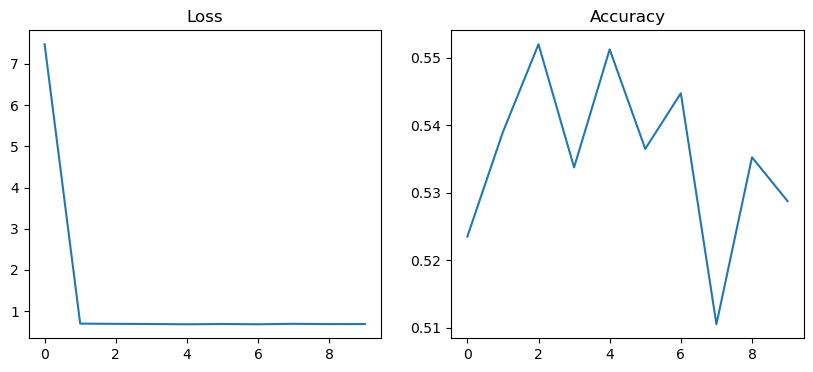

In [13]:
# 打印训练历史记录中的所有键
print(history.history.keys())

# 绘制损失函数和准确率曲线在同一张图上，一左一右
plt.figure(figsize=(10, 4))

# 损失函数曲线在左侧
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')

# 准确率曲线在右侧
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')

# 显示图形
plt.show()


繪製精確率

## 產出預測值

In [14]:
print(X_test.shape)
predictions = network1.predict(X_test)
print(predictions[:5])
predictions = (predictions > 0.5)
print(predictions[:5])

(1000, 16384)
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
[[0.5144374]
 [0.5144374]
 [0.5144374]
 [0.5144374]
 [0.5144076]]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]


0 False - cat

1 True  - dog

              precision    recall  f1-score   support

           0       0.62      0.28      0.39       500
           1       0.54      0.83      0.65       500

    accuracy                           0.56      1000
   macro avg       0.58      0.56      0.52      1000
weighted avg       0.58      0.56      0.52      1000



<Axes: >

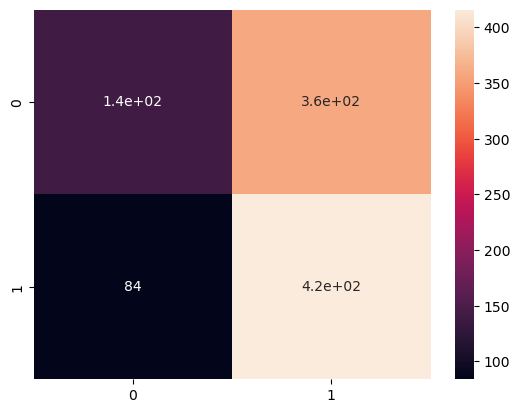

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True)

In [22]:
test_image = X_test[4]
print(test_image)
print(test_image.shape)
test_image = scaler.inverse_transform(test_image.reshape(1, -1))
print(test_image)

[0.18431373 0.19215686 0.18431373 ... 0.05511811 0.05882353 0.06299213]
(16384,)
[[47. 49. 47. ... 15. 15. 17.]]


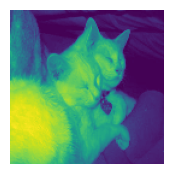

In [23]:
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(test_image.reshape(width, height))

In [25]:
print(network1.predict(test_image))
print(network1.predict(test_image).shape)

ans = 'cat' if network1.predict(test_image) < 0.5 else 'dog'
print(ans)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.58943164]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
dog
